# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

В рамках учебного проекта принимаю следующие условия-допущения:
- вся недвижимость является жилой.
- пользователями вносящие данные в объявление, являются владельцами жилой недвижимости или их представители.
- вся недвижимость в датасете принадлежит вторичному рынку.(цены новостроек и вторичного жилья могут иметь сещественные различия, согласно https://www.restate.ru/graph/)
- столбец 'balcony', объеденяет понятия балкона и лоджии в одну сущность.
- открытая планировка не является студией, а студия является квартирой с нулевым значением комнат.


<a id="id0"></a>
## Содержание: 

[1. **Шаг 1. Откройте файл с данными и изучите общую информацию.**](#id1)<br>
[2. **Шаг 2. Предобработка данных.**](#id2)<br>
[3. **Шаг 3. Посчитайте и добавьте в таблицу**](#id8)<br>
[4. **Шаг 4. Проведите исследовательский анализ данных и выполните инструкции**](#id9)<br>
[5. **Шаг 5. Общий вывод**](#id11)<br>
[**Чек-лист готовности проекта**](#id10)<br>

<a id="id1"></a>
### Шаг 1. Откройте файл с данными и изучите общую информацию. 
[к содержанию](#id0)<br>

In [523]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
try:
    #df=pd.read_csv('C:/projects/real_estate_data.csv', sep='\t')
    df=pd.read_csv(r'/datasets/real_estate_data.csv')
except:
    print('Файл по указанному адресу не найден')
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Вывод

- В данных обнаружены пропуски, в следующих столбцах,
с указанием процентного содержания относительно всех данных:

In [524]:
for i in df.columns:
    t = df[i].isna().sum()/len(df['last_price'])
    if t != 0:
        print('{: <20}'.format(i), '{:.1%}'.format(t))

ceiling_height       38.8%
floors_total         0.4%
living_area          8.0%
is_apartment         88.3%
kitchen_area         9.6%
balcony              48.6%
locality_name        0.2%
airports_nearest     23.4%
cityCenters_nearest  23.3%
parks_around3000     23.3%
parks_nearest        65.9%
ponds_around3000     23.3%
ponds_nearest        61.6%
days_exposition      13.4%


- Некоторые типы данных в столбцах, не удобны для анализа. Они находятся в ниже описанных столбцах и в последуещем, после восполнения пропусков, если таковые имеются, будут заменены:

-balcony, 
-is_apartment
-


<a id="id2"></a>
### Шаг 2. Предобработка данных
[к содержанию](#id0)<br>

#### Устранение логических несоответствий в данных

In [525]:
df[(df['open_plan']!=df['studio']) == (df['rooms']>0)].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1379,3,6000000.0,44.20,2015-11-10T00:00:00,1,NaN,25.0,17.40,23,False,...,NaN,1.0,Санкт-Петербург,10663.0,12738.0,0.0,NaN,0.0,NaN,231.0
2389,5,2250000.0,25.41,2016-06-07T00:00:00,1,NaN,12.0,17.08,8,False,...,NaN,2.0,Санкт-Петербург,14125.0,12921.0,2.0,328.0,2.0,485.0,26.0
3187,13,3800000.0,27.00,2016-05-17T00:00:00,1,NaN,14.0,18.00,8,False,...,NaN,2.0,Санкт-Петербург,50348.0,16053.0,0.0,NaN,0.0,NaN,45.0
4180,4,4500000.0,34.00,2016-04-25T00:00:00,1,2.80,10.0,21.00,10,False,...,NaN,2.0,Санкт-Петербург,23609.0,5299.0,0.0,NaN,1.0,433.0,62.0
5668,9,3550000.0,36.70,2016-04-25T00:00:00,1,2.75,16.0,17.80,2,False,...,NaN,2.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,61.0


Как видно из запроса данных, присутствуют квартиры студии, не со свободной планировкой и количеством комнат не равным нулю. Значения комнат 1 заменяется на 0, тк площади слишком малы для дополнительного жилого помещения в студии, а остальные значения понижаются на еденицу, тк расчеты показывают, что эти Евроквартиры(одна из комнат совмещенная с кухней).

Пример расчета: квартира с площадью 157м.кв. * 0,65(коэффициент экономической эффективности планировки) = 102,5(жил. площадь) -->
102,5 / 5(комнат) = 20.41м.кв. (вполне нормальная площадь комнаты и одна из них совмещена с кухней), поэтому будут выполнена выше описанная операция.

In [526]:
df.loc[(df['open_plan']!=df['studio']) == (df['rooms']>0),'rooms'] -=1

### Обработка пропусков в столбцах и последовательная замена их типов данных

- Столбцы floors_total, locality_name

Строк в столбцах с пропусками количества этажей и названия населенного пункта в сумме меньше процента поэтому их можно отбросить, их появление скоее всего связано с человеческим фактором при заполнении обьявлений. 
Тип данных в столбце floors_total переводится в int тк значение  количественное.

In [527]:
df.drop(df[df['floors_total'].isna()].index,inplace = True)
df.drop(df[df['locality_name'].isna()].index,inplace = True)
df.reset_index(inplace = True)
df['floors_total']=df['floors_total'].astype('int64')

- Столбец Количества балконов 'balcony'.

Пропуски в столбце количества балконов, появились в связи с тем, что это значение в поле заполнения объявления, не является обязательным и при отсутствии балкона, пользователи оставляли это значения пустым, поэтому заполнение пропусков производится нулевыми значениями.

Тип данных в столбце указан как вещецственные величины(что то делимое), хотя значения являются количественными. Поэтому float меняется на int.
PS: даже половина балкона, уже целый балкон.:)

In [528]:
df['balcony'].fillna(0,inplace=True) #заполнение столбца с количеством балконов значением 0
if df['balcony'].isnull().sum()==0:
    print('Пропущенные значения в столбце количества балконов, были заполнены')
df['balcony'] = df['balcony'].astype('int64') #смена типа данных на int  

Пропущенные значения в столбце количества балконов, были заполнены


- Столбец аппартаменты 'is_apartment'

Пропуски в столбце аппартаментов с большой вероятностью связаны с тем, что владельцы жилой недвижимости или их представители, никогда не сталкивались с подобным понятием и не понимают его значения, поэтому и оставляют графу без внимания, однако есть вероятность, что недобрасовестные риэлторы в целях привлечения клиентов, могут не указать, является ли недвижимость аппартаментами(тк стоимость квадратного метра на аппартаменты ориентировочно на 25% ниже согласно https://journal.tinkoff.ru/opasnosti-apartamentov/, что выглядит гораздо привлекательней), из чего, аппартаменты или нет, можно определить по заниженной на 25% средней цене за квадратный метр в квартире, со схожеми параметрами локации. Поэтому, тк. изначально было обозначено допущение о том, что объявления размещают владельцы квартир, все пропуски заполняются значениями False.

Тип данных в столбце указан как object, но по факту все строки имеют будевы значения в этом столбце. Поэтому тип меняется на bool.

In [529]:
df['is_apartment'].fillna(False, inplace=True) #заполнение столбца значением False 
if df['is_apartment'].isnull().sum()==0:
    print('Пропущенные значения в столбце обозначения апартаментов, были заполнены')
df['is_apartment'] = df['is_apartment'].astype('bool') #смена типа данных на bool    

Пропущенные значения в столбце обозначения апартаментов, были заполнены


- Столбец количества дней размещения об-я days_exposition.

Пропуски появились в столбце предполагаю из за того, что выгрузка данных была произведена до того, как обьявления были сняты и количество дней не было сосчитано. Заполнение будет производится разницей между предположительной датой выгрузки данных и датой размещения обьявления. 

In [530]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S') #изменение типа на datetime
df['days_exposition'].fillna(0,inplace=True)#NaN заменяется на 0 для изменения типа данных столбца, тк день целое значение.
df['days_exposition'] = df['days_exposition'].astype('int64') 
last_date = df['first_day_exposition'][0] #случайное значение для сравнения
for i in range(len(df)):
    m = df.loc[i,'first_day_exposition'] + pd.Timedelta(days=df.loc[i,'days_exposition']) #нахождение примерной даты выгрузки
    if m > last_date:
        last_date=m 
last_date_sold = last_date + pd.Timedelta(days=7) # дата последнего снятого обьявленеия перед выгрузкой данных, +7 дней, за которые новые обьявления могли снять 
#строка ниже, 'бывшие' пропуски заполняет разницей между поcледним днем выгрузки данных и датой размещения об-я, изменяя тип данных в int64
df.loc[df['days_exposition']==0,'days_exposition'] = ((last_date_sold - df[df['days_exposition']==0]['first_day_exposition'])/ np.timedelta64(1, 'D')).astype(int)
if len(df.loc[df['days_exposition']==0,'days_exposition'])==0:
    print('Замена выполнена успешно')
else: print('Ошибка записи')

Замена выполнена успешно


- Столбцы parks_nearest, parks_around3000, ponds_around3000, ponds_nearest группа пропусков

Cтоит отметить, что некоторые пропуски имеют групповой характер, пропуски в одном столбце совпадабют расположением в строках с другими столбцами с пропусками. 

In [531]:
#процентное содержание первой группы пропусков
group1 = df[df['airports_nearest'].isna() 
   & df['cityCenters_nearest'].isna() 
   & df['parks_around3000'].isna() 
   & df['parks_nearest'].isna() 
   & df['ponds_around3000'].isna()
   & df['ponds_nearest'].isna()].shape[0]/df.shape[0]
print('Для первой группы столбцов характерно одинаковое количество пропусков, равное {:.0%}'.format(group1))

Для первой группы столбцов характерно одинаковое количество пропусков, равное 23%


Как видно из крупного совпадения количества строк, процент с групповыми пропусками данных возможно были утеряны при совмещеении данных из разных источников, также значение данных связаны с геолокацией, от чего предположение, что алгоритм расчета или определения месторасположения не функционирует в данных областях.

Пропуски в столбцах с растоянием до парка или водоема и столбцы с пропусками с количеством парков и водоемов присутствуют в основном в поселениях не городского типа, что в принципе подтверждает гипотизу отсутствия данных описанную выше, поэтому пропуски заполнятся средним значением по группе поселений не являющимися городами, тк у них, в основном схожая окружающая среда в Лен. обл.. 

Тип данных изменяется на int тк для расстояний доли метров в таком масштабе, мало важны, а количество прудов или парков имеет целое значение.

PS: В столбцах parks_nearest, ponds_nearest процентное содержание пропусков выше следовательно причина возникновения у них может быть другой. Была выявлена еще одна группа ошибок, но об этом ниже.

In [532]:
toponims = ['станции', 'товарищество', 'село','посёлок','деревня'] #топонимы определяющие поселение, как не город.
df['locality_name'] = df['locality_name'].str.replace('поселок','посёлок')
def not_city(value):
    for i in toponims:
        if i in value:
            return True
    return False    
df['not city'] = df[~df['locality_name'].isna()]['locality_name'].apply(not_city) #выявление поселений не являющимися городами
try:
    indexes  = df[df['airports_nearest'].isna() #заполнение номеров строк для первой группы пропусков
    & df['cityCenters_nearest'].isna() 
    & df['parks_around3000'].isna() 
    & df['parks_nearest'].isna() 
    & df['ponds_around3000'].isna()
    & df['ponds_nearest'].isna()].index
except:
    print('Пропуски для этой группы уже заполнены')
df.loc[indexes, 'parks_nearest'] = int(df[df['not city']==True]['parks_nearest'].median())
df.loc[indexes, 'parks_around3000'] = int(df[df['not city']==True]['parks_around3000'].median())
df.loc[indexes, 'ponds_around3000'] = int(df[df['not city']==True]['ponds_around3000'].median())
df.loc[indexes, 'ponds_nearest'] = int(df[df['not city']==True]['ponds_nearest'].median())
print('Пропуски восполнены') 
#исправление логической ошибки, когда имеется расстояние до озера и парка, а количество = 0, присваивается 1.   
for i in range(df.shape[0]):
    if (df.loc[i,'parks_nearest']<3000) and (df.loc[i,'parks_around3000']==0):
        df.loc[i,'parks_around3000'] = 1
    if (df.loc[i,'ponds_nearest']<3000) and (df.loc[i,'ponds_around3000']==0):
        df.loc[i,'ponds_around3000'] = 1
print('Логические несоответствия устранены')    
df.drop('not city', axis='columns',inplace=True) #удаление временного столбца 
df['parks_around3000'] = df['parks_around3000'].astype('int64') #количественное значение
df['ponds_around3000'] = df['ponds_around3000'].astype('int64') #количественное значение 

Пропуски восполнены
Логические несоответствия устранены


- Столбцы parks_nearest, parks_around3000, ponds_around3000 оставшиеся пропуски.



Как видно из данных, пропуски значений в столбцах parks_around3000 , ponds_around3000  совпадают с нулевыми значениями в столбцах ponds_nearest, parks_nearest, это с большей вероятностью говорит о том, что в радиусе 3 км отсутствуют парки и водоемы, поэтому пропуски будут восполнятся условным значением 4000 метров, а количество парков останется неизменным, со значением 0.

In [533]:
#процентное содержание второй группы отсутствия данных
group2 = df[df['parks_nearest'].isna() 
    & (df['parks_around3000']==0)].shape[0]/df.shape[0]
print('Для группы столбцов связанных с отсутствием данных о парках количество равно {:.0%}'.format(group2))
group3 = df[df['ponds_nearest'].isna() & (df['ponds_around3000']==0)].shape[0]/df.shape[0]
print('Для группы столбцов связанных с отсутствием данных о водоемах количество равно равное {:.0%}'.format(group3))            

Для группы столбцов связанных с отсутствием данных о парках количество равно 43%
Для группы столбцов связанных с отсутствием данных о водоемах количество равно равное 38%


Как видно из крупного совпадения количества строк, процент с групповыми пропусками и наличем нулей в данных вероятней всего связан с отсутствием в радиусе трех км парков и водоемов, поэтому, для строк с пропусками имеющих нулевые значения в столбцах ponds_around3000, parks_around3000 будут пресвоены значения 4000 метров.

In [534]:
na_columns2 = ['parks_nearest','ponds_nearest']
df.loc[df['parks_nearest'].isna() 
    & (df['parks_around3000']==0),'parks_nearest'] = 4000
df.loc[df['ponds_nearest'].isna() 
    & (df['ponds_around3000']==0),'ponds_nearest'] = 4000
    
if (df[df['parks_nearest'].isna() & (df['parks_around3000']==0)]['parks_nearest'].sum()==0) == True:
    print('Пропуски в столбце parks_nearest упешно заполнены')
else: print('Ошибка при записи')         
if (df[df['ponds_nearest'].isna() & (df['ponds_around3000']==0)]['ponds_nearest'].sum()==0) == True:
    print('Пропуски в столбце ponds_nearest упешно заполнены')
else: print('Ошибка при записи') 
df['parks_nearest'] = df['parks_nearest'].astype('int64') #точно в сантиметрах нет нужды
df['ponds_nearest'] = df['ponds_nearest'].astype('int64') #по крайней мере для этих расстояний   

Пропуски в столбце parks_nearest упешно заполнены
Пропуски в столбце ponds_nearest упешно заполнены


- Столбец расстояния до центра города cityCenters_nearest

Причина появления пропусков описана в ремарке выше. Приближенно-последним значением для удаленности до центра С-Пб является 66000 метров, поэтому заполнение значений будет производиться условно 80000 метрами, для удобства определения данных удаленных  от области работы алгоритмов геолокации, на графиках.

In [535]:
df.loc[df['cityCenters_nearest'].isna(),'cityCenters_nearest']=80000
if df['cityCenters_nearest'].isna().sum()==0:
    print('Пропуски упешно заполнены')
else: print('Ошибка при записи')    
df['cityCenters_nearest'] = df['cityCenters_nearest'].astype('int64') #сантиметром ближе, сантиметром дальше       

Пропуски упешно заполнены


- Столбец расстояния до аэропорта airports_nearest

Причина появления пропусков описана в ремарке выше. Приближенно-последним значением для удаленности до аэропорта является 85000 метров, поэтому заполнение значений будет производиться условно 100000 метрами, для удобства определения данных удаленных  от области работы алгоритмов геолокации, на графиках.

In [536]:
df.loc[df['airports_nearest'].isna(),'airports_nearest']=100000
if df['airports_nearest'].isna().sum()==0:
    print('Пропуски упешно заполнены')
else: print('Ошибка при записи')    
df['airports_nearest'] = df['airports_nearest'].astype('int64') #в сантиметрах, нет нужды

Пропуски упешно заполнены


- Столбцы kitchen_area, living_area, ceiling_height

Для удобства заполнения пропусков в этих столбцах в которых, необходимо учесть более одного параметра из таблицы, а также используются внешние статестические данные о зависимостях, будет добавлен временный столбец классификации жилой недвижимости (с принятой классификацией можно ознакомиться в статье https://kvartira-bez-agenta.ru/melochi/kakie-klassy-komfortnosti-zhilya-byvayut-na-rynke-nedvizhimosti/) 
По этой ориентировочной классификации будут выбираться среднее значения по городу, для столбцов с пропусками. Для различных классов недвижимости имеются определенные параметры высоты потолков, размера кухонь и коэф. экономической эффективности планировки(отношение жилой площади к общей)

Принадлежность квартиры к классу будет определяться истинной стоимостью за квадратный метр(P_real). Истинная же стоимость, определяется по следующей формуле:
 P_real = S/P * Kapart * K_comb , где S-общая площадь, P-конечная цена, K_apart=0.75 коэф. если недвижимость является аппартаментами, иначе =1, K_komb - является коэффициентом комбинирования K1=0,8 (наличия по близости парков R1=600 https://www.cian.ru/novosti-kak-blizost-parka-vlijaet-na-tsenu-kvartiry-230506/) и K2=0,9 (водоемов R2=600 http://www.bpn.ru/publications/73654), в слечае совместного использования применяется K_komb = 0,8.
Это делается для обьективизации цен.

--Растояние до аэрапорта никак не влияет на на стоимость нидвижиммости, это обьясняется тем, что рядом с аэропортом люди обычно покупают второе жилье, для работы или для сдачи под съем.

--Расстояние до центра города, имеет значения только для квартир находящихся в черте Санкт-Петербурга, потому что значения столбца удаленности от центра остальных населенных пунктов привязаны к Петербургу, а не к локальным центрам. В связи с этим вводится допущение, что удаленность от центра не влияет на стоимость кв. метра (пусть квартиры в Петербурге будут чуточку дороже :) ) 

In [537]:
for i in range(df.shape[0]):
    df.loc[i,'rael_price'] = (df.loc[i,'last_price'] / df.loc[i,'total_area']) * 0.75 if df.loc[i,'is_apartment'] else 1 * 0.8 if (df.loc[i,'parks_nearest']<=600 and df.loc[i,'ponds_nearest']<=600) else (0.8 if df.loc[i,'parks_nearest']<=600 else 1 * 0.9 if (df.loc[i,'ponds_nearest']<=600) else 1)
df['class'] = pd.cut(df['rael_price'],4,labels=['эконом','комфорт','бизнес','премиум'])
df.drop('rael_price',axis='columns', inplace=True) 
group_classes = df.pivot_table(index = 'class', values = ['ceiling_height','kitchen_area','living_area','total_area'],aggfunc='median')
group_classes 

,ceiling_height,kitchen_area,living_area,total_area
class,,,,
эконом,2.65,9.1,30.00,52.00
комфорт,3.50,12.0,48.90,69.30
бизнес,NaN,53.6,72.75,136.85
премиум,51.60,20.0,34.40,92.40


Как видно из таблицы для разных классов жилья, разные высоты потолков. они и присваиваются для пропущенных значений по категориям. В столбце высоты этажа экстримально высокое значение, вероятно это связано с малой выборкой и наличием большого количества экстримальных значений, поэтому условно принемается значение 5 метров из внешних статистических данных.

In [538]:
#заполнение пропусков в столбце высоты этажа
df['ceiling_height'] = df[df['class']=='эконом']['ceiling_height'].fillna(2.65)
#заполнение пропусков в столбце площади кухни
df['kitchen_area'] = df[df['class']=='эконом']['kitchen_area'].fillna(9.1)
#для остального класса жилья принимается зачение 3,5 м (метод fillna отменяет предыдущее заполнение в похожей форме, не понимаю что влияет на это)
#а для остальных классов недвижимости выборка всего 10 строк, от чего не значительна
df['ceiling_height'] = df['ceiling_height'].fillna(3.5)
df['kitchen_area'] = df['kitchen_area'].fillna(15.0)
if df['ceiling_height'].isna().sum()==0:
    print('Пропуски восполнены')
df['kitchen_area'] = df['kitchen_area'].astype('int64') #если расставлять кастрюльки, то половина кв.м. будет важна     

Пропуски восполнены


Добавление в сводную таблицу столбца компоновочных коэффициентов(отношение общей к жилой площади) для классов жилья, далее коэффициенты используются чтобы восполнить пропуски в столбце жилых площадей.

In [539]:
group_classes['coef_area']=group_classes['living_area']/group_classes['total_area']
group_classes

,ceiling_height,kitchen_area,living_area,total_area,coef_area
class,,,,,
эконом,2.65,9.1,30.00,52.00,0.576923
комфорт,3.50,12.0,48.90,69.30,0.705628
бизнес,NaN,53.6,72.75,136.85,0.531604
премиум,51.60,20.0,34.40,92.40,0.372294


In [540]:
#похожая ситуация как и с высотой потолков
df['living_area'] = df[df['class']=='эконом']['living_area'].fillna(0.576923*df['total_area'])
df['living_area'] = df['living_area'].fillna(0.531604*df['total_area']) #для не эконом сегмента количество строк не больше 10
df['living_area'] = df['living_area'].astype('int64')#доли квадратных мертов в квартире важны на малых площадях(как в Японии)

In [541]:
#Удаление временных лишних столбцов
try:
    df.drop('class',axis='columns', inplace=True)    
    df.drop('index',axis='columns', inplace=True)
except KeyError: 
    print('Столбцы уже были удалены') 

### Замена типов данных для оставшихся столбцов

In [542]:
df['last_price'] = df['last_price'].astype('int64') #для обозначения конечной цены не так важны доли , поэтому переводится в int
df['total_area'] = df['total_area'].astype('int64') #мало значимы для генеральной совокупности данных, поэтому int

In [543]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  int64         
 2   total_area            23565 non-null  int64         
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  int64         
 7   living_area           23565 non-null  int64         
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  int64         
 13  balcony         

Вывод: Все пропуски были заполнены, дубликатов найдено не было. Предобработка закончена.

<a id="id8"></a>
### Шаг 3. Посчитайте и добавьте в таблицу
[к содержанию](#id0)<br>

#### Добавление столбцов стоимости квадратного метра, с днем, месяцем и годом разещения обьявления, категориями этажей, с соотношением жил.площади/общей площади.

In [544]:
#добавление столбцa со стоимостью за квадратный метр и приведение его к типу int.
df['cost_square'] = df['last_price']/df['total_area']
df['cost_square'] =df['cost_square'].astype('int64') #на 100 квадратов потеряется не больше 100 рублей в стоимости квартиры
#добавление столбцов с днем, месяцем и годом разещения обьявления.
df['day_of_week_exposition'] = df['first_day_exposition'].dt.weekday
df['month_exposition'] = df['first_day_exposition'].dt.month
df['year_exposition'] = df['first_day_exposition'].dt.year
#добавление столбца с категориями этажей 
df.loc[df['floor']==1,'floor_class'] = 'первый'
df.loc[df['floor']==df['floors_total'],'floor_class'] = 'последний'
df['floor_class'] = df['floor_class'].fillna('другой')
#добавление столбцов с соотношением жил.площади/общей площади и площади кухни/общей площади.
df['relation_living_total'] = df['living_area']/df['total_area']
df['relation_kitchen_total'] = df['kitchen_area']/df['total_area']

In [545]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,cost_square,day_of_week_exposition,month_exposition,year_exposition,floor_class,relation_living_total,relation_kitchen_total
0,20,13000000,108,2019-03-07,3,2.70,16,51,8,False,...,2,755,64,120370,3,3,2019,другой,0.472222,0.231481
1,7,3350000,40,2018-12-04,1,2.65,11,18,1,False,...,0,4000,81,83750,1,12,2018,первый,0.450000,0.275000
2,10,5196000,56,2015-08-20,2,2.65,5,34,4,False,...,2,574,558,92785,3,8,2015,другой,0.607143,0.142857
3,0,64900000,159,2015-07-24,3,2.65,14,91,9,False,...,3,234,424,408176,4,7,2015,другой,0.572327,0.056604
4,2,10000000,100,2018-06-19,2,3.03,14,32,13,False,...,1,48,121,100000,1,6,2018,другой,0.320000,0.410000


Вывод: Необходимые столбцы были добавлены.

<a id="id9"></a>
### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:
[к содержанию](#id0)<br>
[Анализ столбца общей площади в квартире](#id49)<br>
[Анализ столбца с количеством комнат в квартире.](#id48)<br>
[Анализ столбца последней цены указанной в обьявлении, за квартиру.](#id47)<br>
[Анализ столбца с высотой потолков в квартире.](#id46)<br>
[Описание, сколько обычно занимает продажа.](#id44)<br>
[Какие факторы больше всего влияют на стоимость квартиры?](#id45)<br>
[Cамая дорогая стоимость квадратного метра](#id43)<br>
[Выяснение какая область входит в центр](#id42)<br>
[Аналитика сегмента квартир в центре](#id41)<br>

<a id="id49"></a>
### Анализ столбца общей площади в квартире
[к шагу 4](#id9)<br>

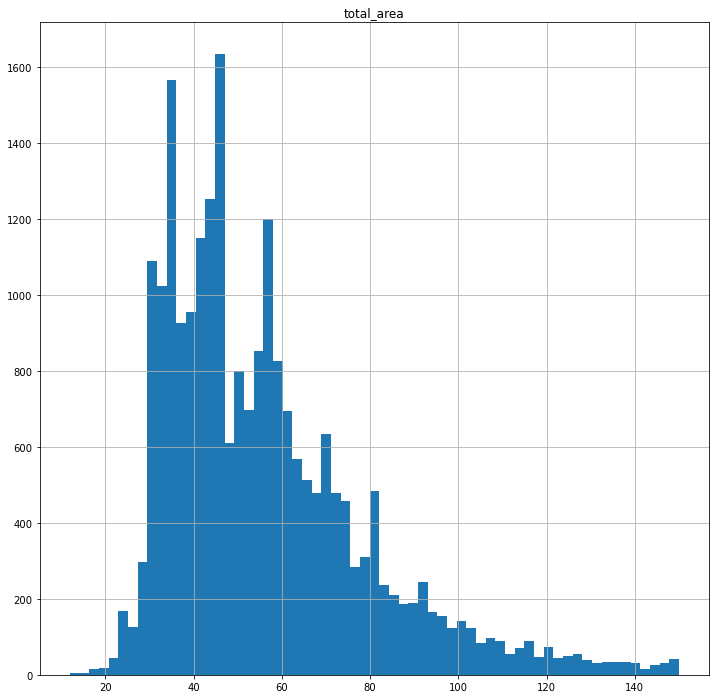

count    23565.000000
mean        60.095226
std         35.668758
min         12.000000
25%         40.000000
50%         52.000000
75%         69.000000
max        900.000000
Name: total_area, dtype: float64


<AxesSubplot:>

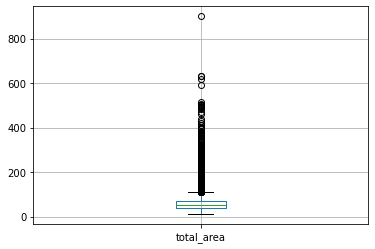

In [546]:
df.hist('total_area',bins=63,figsize=(12,12),range=(12,150))
plt.show()
print(df['total_area'].describe())
df.boxplot('total_area')

Закономерностей колебаний количества одинаковых площадей с другими параметрами выявлено не было, сделаю предположение, что это связано с типовым строительством(типовыми планировками) ЖК(жилых комплексов).

Площади квартир превышающие 150 кв метров являются на рынке малоколичественным предложением которые в виде хвоста на графике, влияют на диаграмму размаха очень сильно.

count    22986.000000
mean        56.221352
std         22.799036
min         12.000000
25%         40.000000
50%         51.000000
75%         67.000000
max        149.000000
Name: total_area, dtype: float64

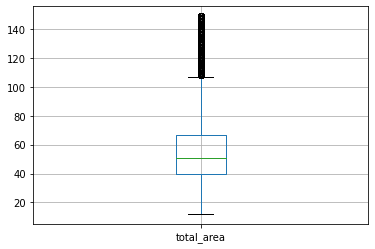

In [547]:
good_stat_t_area = df.query('total_area<150')
good_stat_t_area.boxplot('total_area')
good_stat_t_area['total_area'].describe()

<a id="id48"></a>
### Анализ столбца с количеством комнат в квартире.
[к шагу 4](#id9)<br>

Процент содержания данных 13%
count    23534.000000
mean         2.059403
std          1.036063
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64


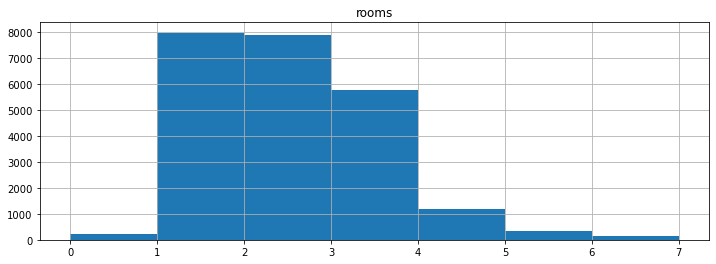

In [548]:
print('Процент содержания данных {:.0%}'.format(df.query('rooms > 7').shape[0]/df.shape[0]*100))
try:
    df = df.drop(df[df['rooms']>7].index).reset_index() #удаление квартир с колич-вом комнат > 7
except:
    print('Данные уже были удалены')
df.hist('rooms',bins=7,figsize=(12,4))
print(df['rooms'].describe())

Обогащая данные из внешних источников и здрвым смыслом, квартиры с количеством комнат превышающиие 6, отбрасывабются, тк на рынке это слишком уникальные предложения и процент содержания в данных не превышает половина процента всех данных, а квартира с 19 комнатами сложно представима.(возможно это небольшой хостел или отель)

Вывод: Из графика видно, что на рынке преобладающее количество квартир, являются 2-х комнатными.

<a id="id47"></a>
### Анализ столбца последней цены указанной в обьявлении, за квартиру.
[к шагу 4](#id9)<br>

count    2.353400e+04
mean     6.480503e+06
std      1.042803e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.625770e+06
75%      6.750000e+06
max      7.630000e+08
Name: last_price, dtype: float64


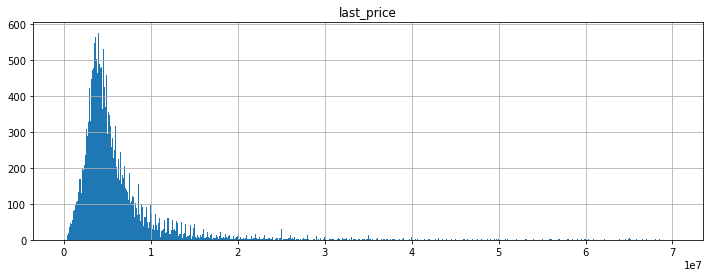

In [549]:
df.hist('last_price',bins=700,figsize=(12,4),range=(0,0.7e8))
print(df['last_price'].describe())
plt.show()

Цены квартир ниже миллиона очень подозрительны, на рынке таких быть не может даже с учетом скидок по ипотеке, поэтому квартиры со стоимостью меньше миллиона отбрасываются. Квартиры превышающие стоимость в 20 млн. вероятней всего относятся к уникальной недвищимости типа апарт комплексов или загородных домов, от чего не отражают действительности на рынке недвижимости, поэтому тоже будут отброшены. 

array([[<AxesSubplot:title={'center':'last_price'}>]], dtype=object)

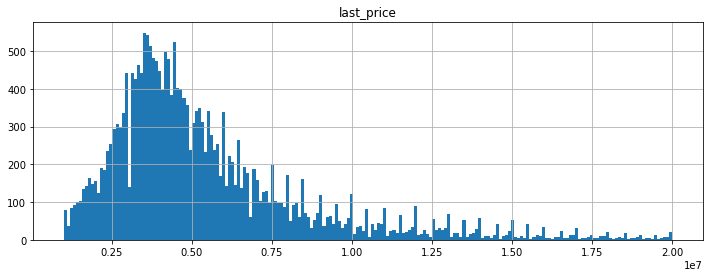

In [550]:
good_price = df.query('last_price>1e6 & last_price<=2e7')
good_price.hist('last_price',bins=200,figsize=(12,4))

Из более подробного графика видны зашумленная тенденция, попробуем выявить причину зашумленности.

array([[<AxesSubplot:title={'center':'last_price'}>]], dtype=object)

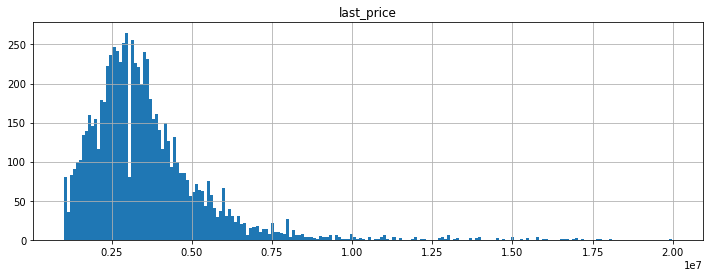

In [551]:
good_price.query('locality_name!="Санкт-Петербург"').hist('last_price',bins=200,figsize=(12,4))

Как видно из графиков зашумленность присутствует в Петербурге, а квартиры в других городах и послениях в принципе подчиняются закону распределения Пуассона, для независымых друг для друга случайных величин, подьем графика выгнутый во вне, это вероятней всего связанно с большим количеством мелких поселений в которых пик количества цен смещен левее.

array([[<AxesSubplot:title={'center':'last_price'}>]], dtype=object)

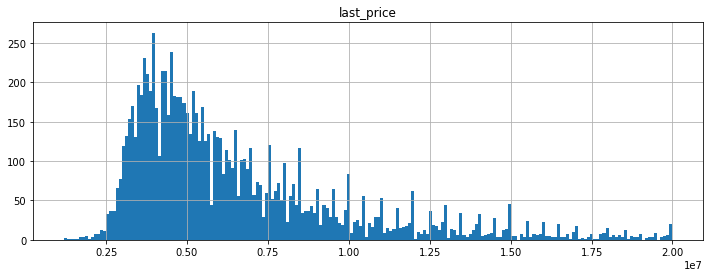

In [552]:
good_price.query('locality_name=="Санкт-Петербург" & balcony==False ').hist('last_price',bins=200,figsize=(12,4))

График похож на Пуассоновский даже больше чем для остальных поселений, но присутствует зашумленность. Эта зашумленность имеет определенный шаг в 500 тыс. из чего можно выдвинуть две гипотезы:

-1 Люди округляют стоимость квартиры до 500 тыс, что вполне вероятно.

-2 Однако это делают не все и вероятней всего это определенный тип людей в своей массе. Предположение следующее, что эти люди продают квартиры в новостройках(возможно в одних и тех же ЖК), тк строительные компании округляют цены при продаже квартир и люди купившие на стадии строительства квартиры, ориентируются на цены застройщика, тк цена за квартиру до переведения квартиры в собственность не зависит от кадастровой стоимости, которая расчитывается по квадратному метру. Так же это обьясняет то, что в большей массе эта зашумленность присутствует в квартирах без балкона(или там где были пропуски). Ведь, к примеру в ДДУ(договор долевого участия, который остается у покупателя) не обозначается площадь балкона, а только общая площадь квартиры, а с планировкой покупатель знакомится только на стадии покупки и получения в собственность. Вообщем люди не заморачивались запрашивать документы для выставления на продажу. 

От чего, допущение сделанное вначале, что все квартиры принадлежат вторичному рынку было не верно. В дальнейшем буду придерживаться второй гипотизы.

count    3.833000e+03
mean     3.425449e+06
std      1.486620e+06
min      1.020000e+06
25%      2.450000e+06
50%      3.200000e+06
75%      4.150000e+06
max      1.780000e+07
Name: last_price, dtype: float64
count    1.877400e+04
mean     5.880208e+06
std      3.281267e+06
min      1.010000e+06
25%      3.700000e+06
50%      4.950000e+06
75%      7.000000e+06
max      2.000000e+07
Name: last_price, dtype: float64


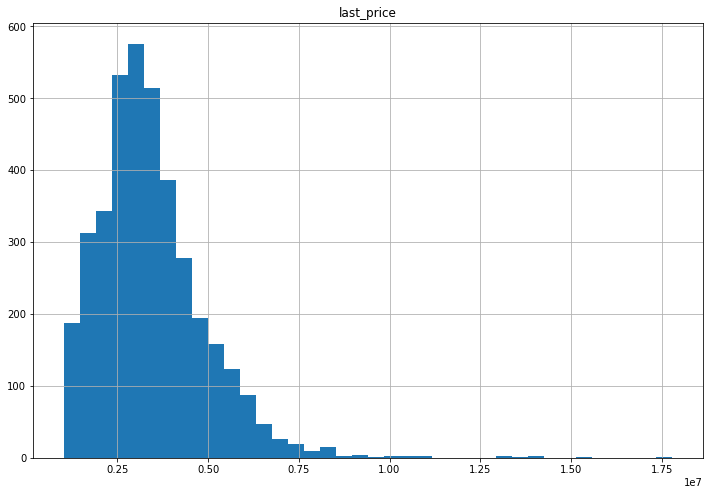

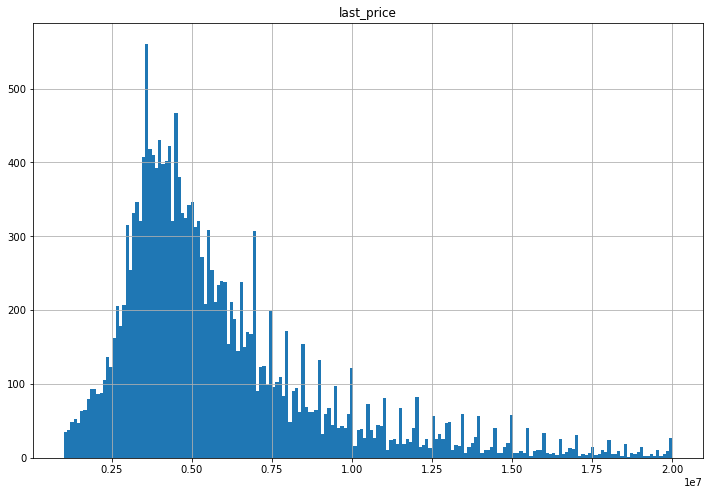

In [553]:
#Counter(good_price['locality_name'])
#выбор поселений, в названии которых больше одного слова(присутствуют топонимы)
other_settlement =  good_price.query('locality_name.str.split().str.len() > 1') 
other_settlement.hist('last_price',bins=38,figsize=(12,8))
print(other_settlement['last_price'].describe())
#выбор поселений, в названии которых одно в названии поселения
city_settlement =  good_price.query('locality_name.str.split().str.len() == 1')
city_settlement.hist('last_price',bins=187,figsize=(12,8))
print(city_settlement['last_price'].describe())

Предположение было верно, общая диаграмма имеет искажение из за наложения гистограм городских и не городских квартир.'Городская' гистограмма имеет боольший хвост, который искажает среднее значение, от чего деаграммы размаха отличаются.

other_settlement


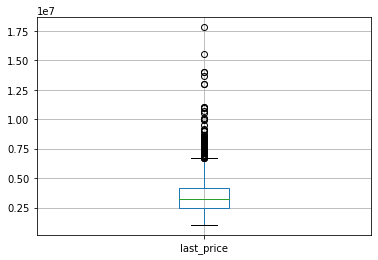

city_settlement


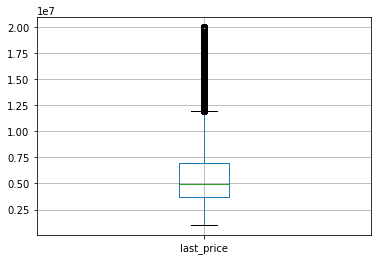

In [554]:
print('other_settlement')
other_settlement.boxplot(column='last_price')
plt.show()
print('city_settlement')
city_settlement.boxplot(column='last_price')
plt.show()

<a id="id46"></a>
### Анализ столбца с высотой потолков в квартире.
[к шагу 4](#id9)<br>

count    23534.000000
mean         2.720078
std          0.762172
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         32.000000
Name: ceiling_height, dtype: float64


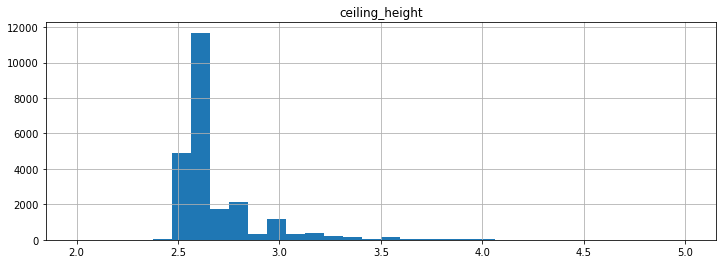

In [555]:
df.hist('ceiling_height',bins=32,figsize=(12,4),range=(2,5))
print(df['ceiling_height'].describe())

Вывод: График грубо похож на распредление Пуассона, как видно из него, преобладающее количество квартир имеют высоту 2.5-2.6 метров, с более высоким уровнем потолков, встречаются гораздо меньше.  

<a id="id44"></a>
### Описание, сколько обычно занимает продажа.
[к шагу 4](#id9)<br>

In [556]:
df['days_exposition'].describe()

count    23534.000000
mean       186.473230
std        233.366404
min          1.000000
25%         44.000000
50%         94.000000
75%        237.000000
max       1625.000000
Name: days_exposition, dtype: float64

Вывод: Необычно быстные продажи можно считать, когда квартиры продаются в течения одного месяца это показывает первый квартиль, а после  до семи с половиной месяцев квартиры имеют средний период продажи остальные значения говорят о необычайно долгой продаже.

<a id="id45"></a>
### Какие факторы больше всего влияют на стоимость квартиры?
[к шагу 4](#id9)<br>


#### Зависимость стоимости квартиры от общей площади квартиры

0.6422330966154141

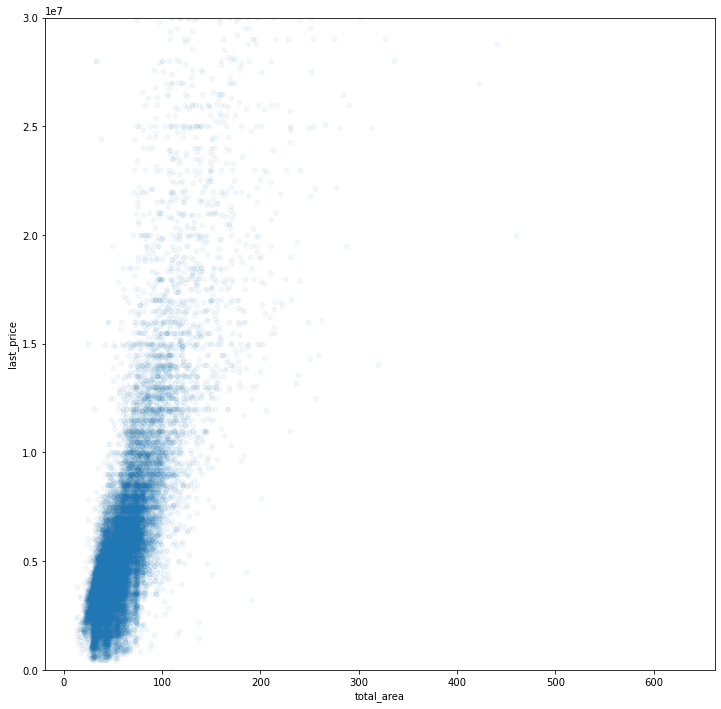

In [557]:
df.plot(x='total_area', y='last_price',kind='scatter', figsize=(12,12), ylim=(0,3e7),alpha=0.05)
df['total_area'].corr(df['last_price'])

Вывод: Основная масса квартир до 15 млн. и до 100м.кв имеют вполне понятный направленный диапозон отношения цены и площади, дальше в цена никак не зависит от площади и площадь от цены. 
Коэф. кореляции = 0,64

#### Зависимость стоимости квартиры от количества комнат квартиры

0.35075826890668654

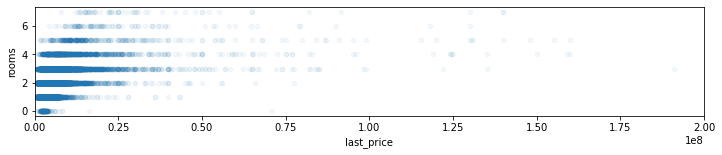

In [854]:
df.plot(x='last_price', y='rooms',kind='scatter', figsize=(12,2),xlim=(0,2e8),alpha=0.05)
df['last_price'].corr(df['rooms'])

Вывод: Стоимость квартиры растет уверенно до трех комнатных квартир, потом стоимость за квартиру в зависимости от кол-ва комнат падает. Снижение стоимости может быть обусловленна отдаленным расположением от центра. 

Коэф. кореляции = 0,35

#### Разница стоимости квартиры от расположения на первом или последнем этажах

<AxesSubplot:xlabel='last_price', ylabel='floor_class'>

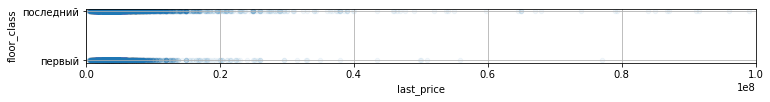

In [559]:
first_and_end = df.query('floor_class != "другой"')
first_and_end.plot(x='last_price', y='floor_class',kind='scatter', figsize=(12,1), grid=True, xlim=(0,1e8),alpha=0.05)

Вывод: Стоимость первых этажей заметно дешевле остальных.

#### Зависимость стоимости квартиры от удаленности от центра

-0.21103744574881114

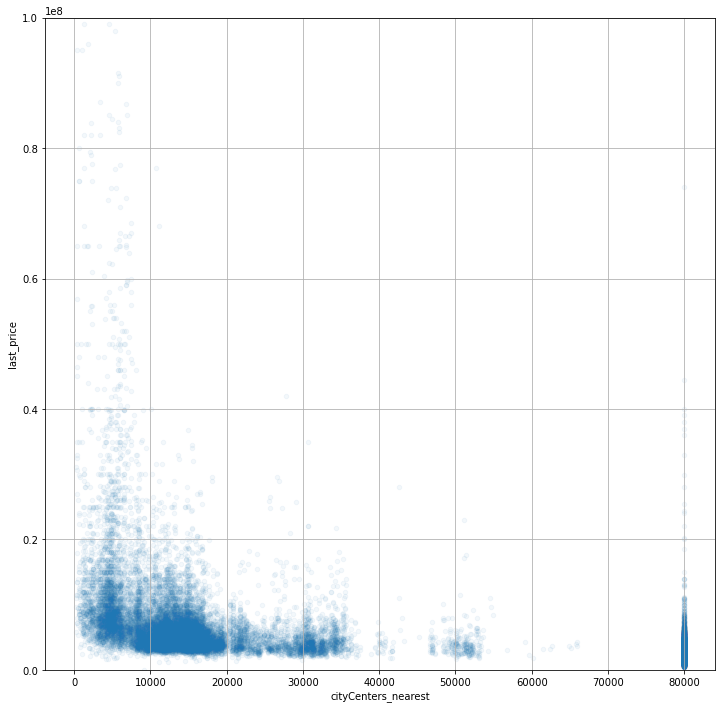

In [560]:
df.plot(x='cityCenters_nearest', y='last_price',kind='scatter', figsize=(12,12), grid=True,ylim=(0,1e8),alpha=0.05)
df['last_price'].corr(df[df['cityCenters_nearest']<80000]['cityCenters_nearest'])

Вывод: Как видно из диаграммы квартиры приближенные к центру Петербурга имеют более высокиий разброс цен. Выброс на отметке 80 тыс.метров является условным заполнением пропусков вне радиуса определения геолокации. Однако коэф.Пирсона не имеет сильной зависимости для всего региона, поэтому нужно рассматривать в черте города.

Коэф. кореляции = -0,21

Общий вывод: Больше всего влияет параметр количества квартир, там сыамый высокий коэф кореляции.

#### Зависимость стоимости квартиры от даты размещения

<AxesSubplot:xlabel='last_price', ylabel='day_of_week_exposition'>

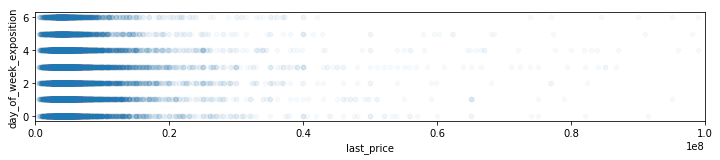

In [853]:
df.plot(x='last_price',y='day_of_week_exposition',kind='scatter',alpha=0.03, xlim=(0,1e8),figsize=(12,2))

Вывод: На выходных обьявления размещают квартиры с более низкой ценой, чем в будние дни.

<AxesSubplot:xlabel='last_price', ylabel='month_exposition'>

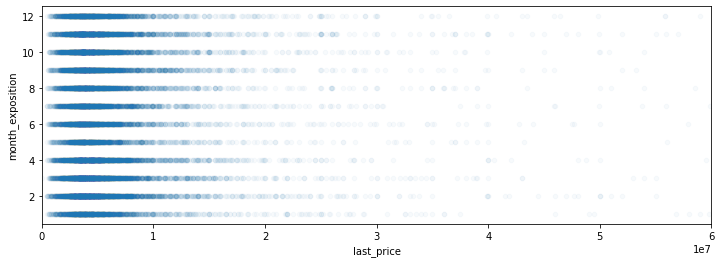

In [562]:
df.plot(x='last_price',y='month_exposition',kind='scatter',alpha=0.03, xlim=(0,6e7),figsize=(12,4))

Вывод: В летний период и в первом и последнем месях, обьявления размещают с ценой за квартиру более низкой. 

<AxesSubplot:xlabel='last_price', ylabel='year_exposition'>

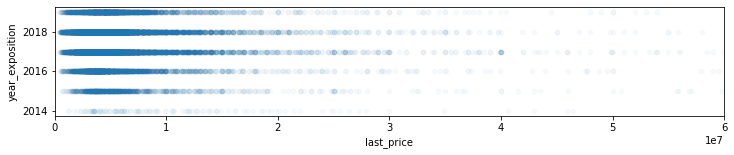

In [851]:
df.plot(x='last_price',y='year_exposition',kind='scatter',alpha=0.03, xlim=(0,6e7),figsize=(12,2))

Вывод: Стоимость квартир до 2018, в общей массе росла.

<a id="id43"></a>
###  Cамая дорогая стоимость квадратного метра из 10 населённых пунктов с наибольшим числом объявлений.
[к шагу 4](#id9)<br>

In [596]:
group_localsion = df.groupby('locality_name')
group_localsion_most = group_localsion.index.count().sort_values(ascending=False).head(10).index
group_localsion_most

Index(['Санкт-Петербург', 'посёлок Мурино', 'посёлок Шушары', 'Всеволожск',
       'Пушкин', 'Колпино', 'посёлок Парголово', 'Гатчина', 'деревня Кудрово',
       'Выборг'],
      dtype='object', name='locality_name')

In [597]:
df.query('locality_name in @group_localsion_most').groupby('locality_name')['cost_square'].mean().sort_values(ascending=False).astype('int64')

locality_name
Санкт-Петербург      115301
Пушкин               103610
деревня Кудрово       93001
посёлок Парголово     90675
посёлок Мурино        86253
посёлок Шушары        78943
Колпино               75644
Гатчина               69045
Всеволожск            68984
Выборг                58295
Name: cost_square, dtype: int64

Вывод: В десятке городов с самым крупным количеством обьявлений, самая дорогая стоимость квадратного метра находится в Петербурге, а самая дешевая в Выборге

<a id="id42"></a>
### Выяснение какая область входит в центр
[к шагу 4](#id9)<br>

,cityCenters_nearest_km,last_price
0,0,2.344232e+07
1,1,1.871998e+07
2,2,1.587986e+07
3,3,1.308931e+07
4,4,1.347452e+07
5,5,1.509116e+07
6,6,1.438911e+07
7,7,1.162290e+07
8,8,8.430806e+06
9,9,6.361792e+06


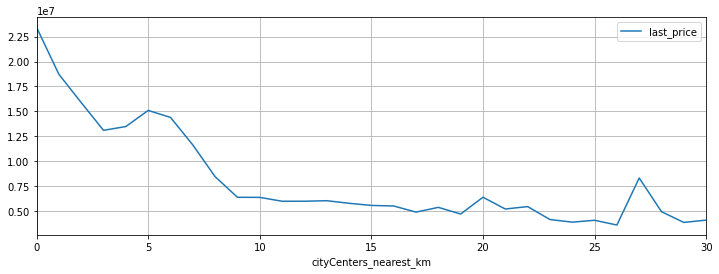

In [655]:
df['cityCenters_nearest_km'] = df['cityCenters_nearest']//1000
pivot_spb = df.query('locality_name=="Санкт-Петербург"').pivot_table(index='cityCenters_nearest_km',values='last_price').reset_index()
pivot_spb.plot( y='last_price', x='cityCenters_nearest_km', figsize=(12,4),xlim=(0,30),grid=True)
pivot_spb.head(10)

Вывод: Как видно из диаграммы, граница центра находится на девятом километре. Далее снижение цены происходит не так активно.

<a id="id41"></a>
### Аналитика сегмента квартир в центре
[к шагу 4](#id9)<br>

In [850]:
spb_stat = df.query('locality_name=="Санкт-Петербург"')
center_spb_stat = df.query('cityCenters_nearest_km<9')
center = center_spb_stat.describe()
others = spb_stat.describe()
for i in ['total_area','last_price','rooms','ceiling_height']:
    print('Столбец ',i)
    print('Данные по центру города')
    print(center[i])
    print('Данные по городу')
    print(others[i])
    print()

Столбец  total_area
Данные по центру города
count    4348.000000
mean       87.076817
std        54.598635
min        12.000000
25%        53.000000
50%        74.000000
75%       104.000000
max       631.000000
Name: total_area, dtype: float64
Данные по городу
count    15621.000000
mean        64.059023
std         38.610896
min         12.000000
25%         42.000000
50%         55.000000
75%         74.000000
max        631.000000
Name: total_area, dtype: float64

Столбец  last_price
Данные по центру города
count    4.348000e+03
mean     1.351519e+07
std      2.189217e+07
min      1.600000e+06
25%      6.200000e+06
50%      8.695000e+06
75%      1.345000e+07
max      7.630000e+08
Name: last_price, dtype: float64
Данные по городу
count    1.562100e+04
mean     7.980043e+06
std      1.244306e+07
min      1.219000e+04
25%      4.200000e+06
50%      5.500000e+06
75%      8.100000e+06
max      7.630000e+08
Name: last_price, dtype: float64

Столбец  rooms
Данные по центру города
count    

#### Сравнение влияния количества комнат на цену квартиры по всему городу и в центре

<AxesSubplot:xlabel='last_price', ylabel='rooms'>

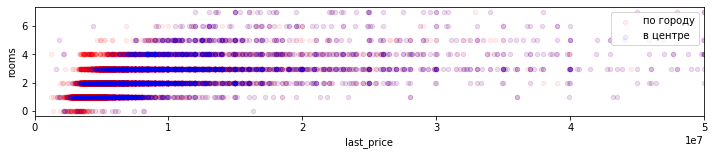

In [805]:
ax =spb_stat.plot(x='last_price',y='rooms',kind='scatter',alpha=0.07,color='red',xlim=(0,3e7),figsize=(12,4),label='по городу')
center_spb_stat.plot(ax =ax, x='last_price',y='rooms',kind='scatter',alpha=0.07,color='blue',xlim=(0,5e7),figsize=(12,2),label='в центре')

Вывод: Рост цены для квартир в центре в зависимости от количества комнат более активный.

#### Сравнение влияния высоты этажа на цену квартиры по всему городу и в центре

<AxesSubplot:xlabel='last_price', ylabel='floor'>

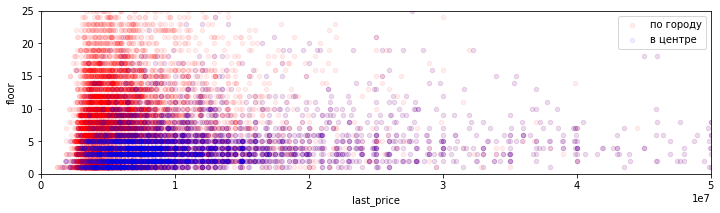

In [804]:
ax =spb_stat.plot(x='last_price',y='floor',kind='scatter',alpha=0.07,color='red',xlim=(0,3e7),figsize=(12,4),label='по городу')
center_spb_stat.plot(ax =ax, x='last_price',y='floor',kind='scatter',alpha=0.07,color='blue',xlim=(0,5e7),ylim=(0,25),figsize=(12,3),label='в центре')

Вывод: Как видно в центре дома в основном более низкой постройки, а цены начинаются с более высокой стоимостной планки. 

#### Сравнение влияния расстояния от центра на цену квартиры по всему городу и в центре

<AxesSubplot:xlabel='last_price', ylabel='cityCenters_nearest_km'>

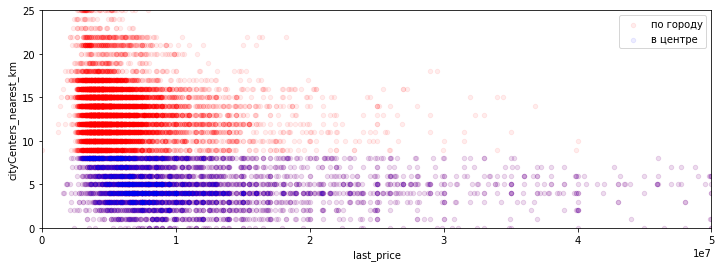

In [803]:
ax =spb_stat.plot(x='last_price',y='cityCenters_nearest_km',kind='scatter',alpha=0.07,color='red',xlim=(0,3e7),figsize=(12,4),label='по городу')
center_spb_stat.plot(ax =ax, x='last_price',y='cityCenters_nearest_km',kind='scatter',alpha=0.07,color='blue',xlim=(0,5e7),ylim=(0,25),figsize=(12,4),label='в центре')

Вывод: Видно что для центра предложений с высокой стоимостью квартиры много, в черте города имеются также высокостоимостные предложения, однако не так много.

#### Сравнение даты размещения обьявления на цену квартиры по всему городу и в центре

<AxesSubplot:xlabel='last_price', ylabel='day_of_week_exposition'>

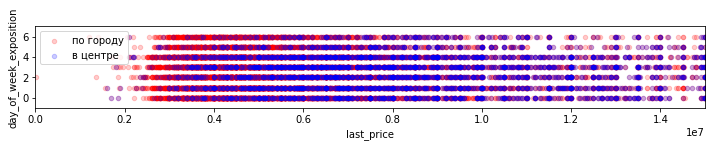

In [840]:
ax =spb_stat.plot(x='last_price',y='day_of_week_exposition',kind='scatter',alpha=0.2,color='red',xlim=(0,3e7),figsize=(12,4),label='по городу')
center_spb_stat.plot(ax =ax, x='last_price',y='day_of_week_exposition',kind='scatter',alpha=0.2,color='blue',xlim=(0,1.5e7),ylim=(-1,7),figsize=(12,1.5),label='в центре')

<AxesSubplot:xlabel='last_price', ylabel='month_exposition'>

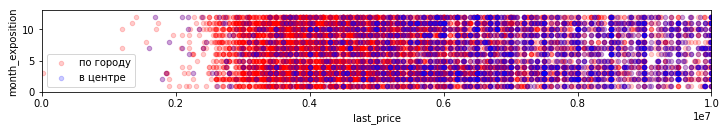

In [844]:
ax =spb_stat.plot(x='last_price',y='month_exposition',kind='scatter',alpha=0.2,color='red',xlim=(0,3e7),figsize=(12,4),label='по городу')
center_spb_stat.plot(ax =ax, x='last_price',y='month_exposition',kind='scatter',alpha=0.2,color='blue',xlim=(0,1e7),ylim=(0,13),figsize=(12,1.5),label='в центре')

<AxesSubplot:xlabel='last_price', ylabel='year_exposition'>

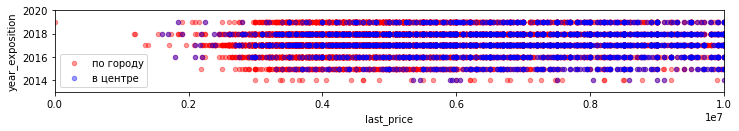

In [846]:
ax =spb_stat.plot(x='last_price',y='year_exposition',kind='scatter',alpha=0.4,color='red',xlim=(0,3e7),figsize=(12,4),label='по городу')
center_spb_stat.plot(ax =ax, x='last_price',y='year_exposition',kind='scatter',alpha=0.4,color='blue',xlim=(0,1e7),ylim=(2013,2020),figsize=(12,1.5),label='в центре')

Вывод: Для обьявлений квартир находящихся в центре имеются некоторые особенности в отличие от обьявлений для квартир по всему городу:

- Большее количество дешевых квартир для центра, на продажу размещают в начале недели.
- Месяц никак не влияет на размещение квартир в центе , в отличии от квартир для всего города, где к концу лета размещают более дорогие.
- В разные года тенденция размещения обьявления для квартиры из центра не отличается от обьявления квартиры во всем городе

<a id="id11"></a>
### Шаг 5. Общий вывод
[к содержанию](#id0)<br>

1 В данных имеются пропуски и ошибки, в принципе часть их была восполнима за счет других данных в таблице(типа жилой площади или площади кухни), возникновение же других, стоит уточнить у инженеров(данные касающиеся расстояний).
2 Были добавлены стлбцы  стоимости квадратного метра, с днем, месяцем и годом разещения обьявления, категориями этажей, с соотношением жил.площади/общей площади, для дальнейшего удобства оценки квартир.
3 Исследовательский анализ показал, что стоимость квартиры имеет неоднородную кореляцию от различных параметров: количества комнат, расстояния до центра, этажа где расположена квартира и общей площади.

Также квартиры в центре города имеют свои отличия:
- в среднем и медианном значении по общей площади больше чем для всего города
- в среднем и медианном значении цены за квартиры значительно выше
- в среднем и медианном значении высота потолков в квартирах в центре выше на 10-20 см
- имеют более артивный рост цены при увеличении количества комнат
- более дешевые квартиры рамещают в обьявлениях в начале недели
- квартиры находятся в невысоких домах(до 6 этажей), это в принципе подтверждается высотным регламентом в центре города.